In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime as dt
import seaborn
import calendar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
!pip install meteostat

In [3]:
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_train_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [4]:
print(df_transactions.date.max())
print(df_train_partial.date.max())
print(df_test_partial.date.max())

2017-08-15
2017-08-15
2017-08-31


In [5]:
from meteostat import Stations

stations = Stations()
stations = stations.region('EC')
# should specfify per region
stations.fetch(10)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
84001,Seymour Galapagos,EC,W,84001,SEGS,-0.4500,-90.2667,16.0,Pacific/Galapagos,1942-08-01,2023-07-07,1942-09-15,1945-09-30,1942-01-01,1945-01-01
84008,San Cristobal Galapagos,EC,W,84008,SEST,-0.9000,-89.6000,6.0,Pacific/Galapagos,1973-06-16,2023-07-07,1985-04-18,2023-07-04,1975-01-01,2021-01-01
84010,San Cristobal Aeropuerto (galapagos) / San Cri...,EC,W,84010,<NA>,-0.9103,-89.6175,18.0,Pacific/Galapagos,2010-09-01,2023-05-13,NaT,NaT,NaT,NaT
84015,Chone / San Pablo / Peludo,EC,M,84015,SECH,-0.7000,-80.1167,69.0,Pacific/Galapagos,2006-03-06,2018-02-28,NaT,NaT,NaT,NaT
84018,Esmeraldas-Tachina,EC,E,84018,SEES,0.9667,-79.6333,7.0,Pacific/Galapagos,1973-01-01,2008-11-06,NaT,NaT,NaT,NaT
84027,Tulcan / El Rosal,EC,C,84027,SETU,0.8167,-77.7000,2950.0,Pacific/Galapagos,1938-09-02,2023-07-07,NaT,NaT,NaT,NaT
84036,San Gabriel,EC,C,84036,<NA>,0.6042,-77.8194,2860.0,America/Guayaquil,2003-04-04,2023-05-13,2011-07-16,2023-07-03,2009-01-01,2021-01-01
84043,Ibarra / Atahualpa,EC,I,84043,SEIB,0.3500,-78.1333,2228.0,Pacific/Galapagos,1980-04-01,2018-11-01,NaT,NaT,1975-01-01,1982-01-01
84050,La Concordia,EC,P,84050,<NA>,0.0267,-79.3714,360.0,America/Guayaquil,2003-04-04,2023-05-13,2005-09-20,2023-07-03,2009-01-01,2021-01-01


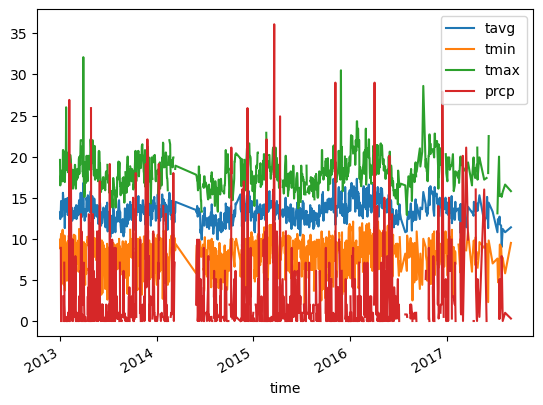

,date,tavg,tmin,tmax,prcp
0,2013-01-01,13.20,9.90,19.60,4.10
1,2013-01-02,12.40,8.80,16.50,0.00
2,2013-01-03,13.20,9.80,17.00,0.00
3,2013-01-04,13.50,9.90,17.70,8.90
4,2013-01-05,14.60,10.60,17.90,0.00
5,2013-01-06,13.60,9.60,17.90,0.00
6,2013-01-07,12.90,8.60,17.30,0.00
7,2013-01-08,13.90,4.60,18.30,0.00
8,2013-01-09,12.70,5.40,18.30,0.00
9,2013-01-10,13.90,10.80,17.00,0.00


In [6]:
# !pip install meteostat
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = pd.Timestamp(df_train_partial.date.min())
end = pd.Timestamp(df_test_partial.date.max())

# Create Point for Vancouver, BC
# 
# vancouver = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
df_weather = Daily('84036', start, end)
df_weather = df_weather.fetch()[['tavg', 'tmin', 'tmax', 'prcp']]

# Plot line chart including average, minimum and maximum temperature
df_weather.plot(y=['tavg', 'tmin', 'tmax', 'prcp'])
plt.show()
df_weather.prcp = df_weather.prcp.fillna(0)
df_weather = df_weather.resample('D').first().interpolate(method='linear').bfill() #  fill first value
df_weather = df_weather.ffill()
df_weather = df_weather.reset_index().rename({'time': 'date'}, axis=1)
df_weather.date = pd.to_datetime(df_weather.date)
# print(pd.date_range(start=start, end=end).difference(df_weather.date))
df_weather.head(60)

In [7]:
# convert to timestamp and remove leading 0s
df_train_partial.date = pd.to_datetime(df_train_partial.date)
df_test_partial.date = pd.to_datetime(df_test_partial.date)
df_train_partial = df_train_partial.sort_values(['store_nbr', 'family', 'date']).groupby(['store_nbr', 'family']).apply(lambda x: x[x.sales.cumsum()>0]).reset_index(drop=True)

**Cleaning Oil Data**
* Linearly interpolate weekends
* Add 7-day and 30-day moving averages
* Add 7-day and 30-day rolling max

In [8]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_oil = df_oil.set_index('date')
df_oil.index = pd.to_datetime(df_oil.index)
df_oil = df_oil.resample('D').first().interpolate(method='linear').bfill() #  fill first value
df_oil = df_oil.rename({'dcoilwtico': 'price'}, axis=1)
df_oil['price_7d_ma'] = df_oil.price.rolling(7).mean().bfill()
df_oil['price_30d_ma'] = df_oil.price.rolling(30).mean().bfill()
df_oil['price_7d_max'] = df_oil.price.rolling(7).max().bfill()
df_oil['price_30d_max'] = df_oil.price.rolling(30).max().bfill()
df_oil['price_7d_min'] = df_oil.price.rolling(7).min().bfill()
df_oil['price_30d_min'] = df_oil.price.rolling(30).min().bfill()

**Cleaning Holiday Data**

In [9]:
def clean_hol(x):
    if ':' in x:
        return x.split(':')[0]
    if '-' in x:
        return x.split('-')[0]
    if '+' in x:
        return x.split('+')[0]
    return x

df_hols = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_hols['holiday_description_clean'] = df_hols.description.apply(clean_hol)
df_hols = df_hols[~df_hols.transferred].drop(['transferred'], axis=1)
df_hols = df_hols.rename(
    {'type': 'holiday_type', 
     'description': 'holiday_description'
    }, axis=1)
df_hols.date = pd.to_datetime(df_hols.date)
    
holiday_loc = df_hols[df_hols.locale == 'Local']
holiday_reg = df_hols[df_hols.locale == 'Regional']
holiday_nat = df_hols[df_hols.locale == 'National']

holiday_loc.rename(columns={'locale_name': 'city'},
          inplace=True, errors='raise')
holiday_reg.rename(columns={'locale_name': 'state'},
          inplace=True, errors='raise')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_stores = df_stores.rename(
    {
        'type': 'store_type',
    }, axis=1)

In [11]:
min_date = df_train_partial.date.min()
max_date = df_test_partial.date.max()
df_cal = pd.DataFrame(index=pd.date_range(min_date, max_date))
df_cal['day_of_week'] = df_cal.index.map(dt.isoweekday)
df_cal['is_weekend'] = df_cal.day_of_week >= 5
df_cal['month_of_year'] = df_cal.index.map(lambda x: x.month)
df_cal['day_of_year'] = df_cal.index.map(lambda x: x.timetuple().tm_yday)
df_cal['week_of_year'] = df_cal.day_of_year//7+1
df_cal['day_of_month'] = df_cal.index.map(lambda x: x.day)
df_cal['is_wage_day'] = df_cal.index.map(lambda x: x.day in [15, calendar.monthrange(x.year, x.month)[1]])
df_cal['is_wage_day_after'] = df_cal.is_wage_day.shift().fillna(False)

In [12]:
n = 20
print('-'*10, 'Oil Prices', '-'*10)
print(df_oil.head(n))
print('-'*10, 'Calendar', '-'*10)
print(df_cal.head(n))
print('-'*10, 'Holidays', '-'*10)
print(df_hols.head(n))
print('-'*10, 'Stores', '-'*10)
print(df_stores.head(n))
print('-'*10, 'Training data', '-'*10)
print(df_train_partial.head(n))
print('-'*10, 'Test data', '-'*10)
print(df_test_partial.head(n))
print('-'*10, 'Transactions', '-'*10)
print(df_transactions.head(n))
print('-'*10, 'Weather', '-'*10)
print(df_weather.head(n))

---------- Oil Prices ----------
                price  price_7d_ma  price_30d_ma  price_7d_max  price_30d_max  \
date                                                                            
2013-01-01  93.140000    93.127143     94.607333     93.200000          97.98   
2013-01-02  93.140000    93.127143     94.607333     93.200000          97.98   
2013-01-03  92.970000    93.127143     94.607333     93.200000          97.98   
2013-01-04  93.120000    93.127143     94.607333     93.200000          97.98   
2013-01-05  93.146667    93.127143     94.607333     93.200000          97.98   
2013-01-06  93.173333    93.127143     94.607333     93.200000          97.98   
2013-01-07  93.200000    93.127143     94.607333     93.200000          97.98   
2013-01-08  93.210000    93.137143     94.607333     93.210000          97.98   
2013-01-09  93.080000    93.128571     94.607333     93.210000          97.98   
2013-01-10  93.810000    93.248571     94.607333     93.810000          97.9

<Axes: xlabel='date'>

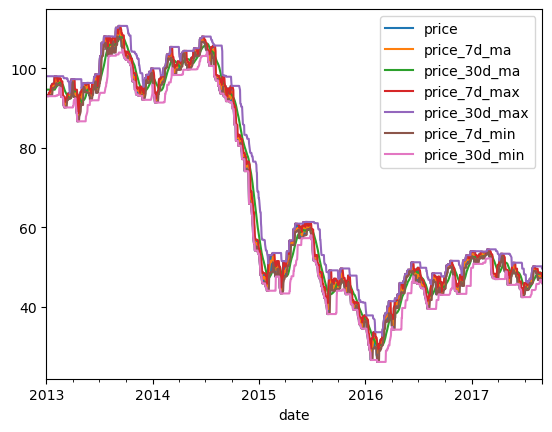

In [13]:
df_oil.plot()

In [14]:
def preprocess(df_in, label_encoder_map=None):
    print('merging...')
    df_out = df_in\
        .merge(df_stores, how='inner', on='store_nbr')\
        .merge(df_oil, how='inner', on='date')\
        .merge(df_weather, how='inner', on='date')\
        .merge(df_cal, how='inner', left_on='date', right_index=True).copy()


    df_out_loc = pd.merge(df_out, holiday_loc, on=['date', 'city'], how='left')
    df_out_loc = df_out_loc[~(df_out_loc.holiday_type == 'Holiday')]
    
    df_out_reg = pd.merge(df_out, holiday_reg, on=['date', 'state'], how='left')
    df_out_reg = df_out_reg[~(df_out_reg.holiday_type == 'Holiday')]
    
    df_out_nat = pd.merge(df_out, holiday_nat, on=['date'], how='left') 
    df_out_nat = df_out_nat[~(df_out_nat.holiday_type == 'Holiday')]
    
    df_out = pd.concat([df_out_loc, df_out_reg, df_out_nat])
    

    df_out = df_out[~df_out.id.duplicated(keep='first')]
    df_out = df_out.drop(['locale', 'locale_name'], axis=1, errors='ignore')
    
    col_encode = [
        'family',
        'holiday_type',
        'holiday_description',
        'holiday_description_clean',
        'city',
        'state',
        'store_type',
    ]
    
    if 'sales' in df_out:
        print('Scaling...')
#         scaler = MinMaxScaler()
#         scaler = PowerTransformer(method='box-cox', standardize=False)
        scaler = PowerTransformer(method='yeo-johnson', standardize=False)
#         scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#         scaler = StandardScaler()
        df_out['sales_transformed'] = scaler.fit_transform(np.array(df_out.sales).reshape(-1, 1))
    else:
        scaler = None
    
    print('computing label encoding...')
    if label_encoder_map is None:
        label_encoder_map = {}
        for col in col_encode:
            if col not in df_out: continue
            le = preprocessing.LabelEncoder()
            df_out[col] = le.fit_transform(df_out[col])
            label_encoder_map[col] = le
    else:
        for col in col_encode:
            if col not in df_out: continue
            le = label_encoder_map[col]
            df_out[col] = le.transform(df_out[col])
            
    assert df_in.shape[0] == df_out.shape[0]
    return df_out, label_encoder_map, scaler  # should fillna only to specific columns!

df_train, label_encoder_map, scaler = preprocess(df_train_partial)
print(df_train.columns)
print(df_train_partial.shape)
df_train.shape

merging...
Scaling...
computing label encoding...
Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'price', 'price_7d_ma',
       'price_30d_ma', 'price_7d_max', 'price_30d_max', 'price_7d_min',
       'price_30d_min', 'tavg', 'tmin', 'tmax', 'prcp', 'day_of_week',
       'is_weekend', 'month_of_year', 'day_of_year', 'week_of_year',
       'day_of_month', 'is_wage_day', 'is_wage_day_after', 'holiday_type',
       'holiday_description', 'holiday_description_clean',
       'sales_transformed'],
      dtype='object')
(2444680, 6)


(2444680, 33)

In [15]:
df_train = df_train.sort_values(['store_nbr', 'family', 'date'])
# df_train['sales_diff'] = df_train.groupby(['store_nbr', 'family']).sales.pct_change().fillna(0)
# df_train.tail(60)
# df_train[['date', 'sales_diff']].plot(x='date', y='sales_diff')

In [16]:
df_train.describe()

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,price,...,prcp,day_of_week,month_of_year,day_of_year,week_of_year,day_of_month,holiday_type,holiday_description,holiday_description_clean,sales_transformed
count,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,...,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06,2.444680e+06
mean,1.646753e+06,2.690373e+01,1.629448e+01,4.391761e+02,3.194947e+00,1.249631e+01,8.797183e+00,2.013993e+00,8.554193e+00,6.410585e+01,...,2.220184e+00,3.997778e+00,6.223554e+00,1.739002e+02,2.541497e+01,1.564195e+01,1.997374e+00,3.997985e+00,2.998129e+00,3.308075e+00
std,8.294128e+05,1.560982e+01,9.348209e+00,1.206212e+03,1.346766e+01,6.317114e+00,4.158184e+00,1.187669e+00,4.726763e+00,2.478298e+01,...,4.165544e+00,2.000934e+00,3.373424e+00,1.030578e+02,1.472536e+01,8.791749e+00,7.214735e-02,6.184054e-02,5.499734e-02,2.278222e+00
min,5.630000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
25%,9.740068e+05,1.300000e+01,9.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,4.000000e+00,4.591000e+01,...,0.000000e+00,2.000000e+00,3.000000e+00,8.600000e+01,1.300000e+01,8.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,1.356813e+00
50%,1.698272e+06,2.700000e+01,1.600000e+01,3.200000e+01,0.000000e+00,1.400000e+01,1.000000e+01,2.000000e+00,9.000000e+00,5.144000e+01,...,5.000000e-01,4.000000e+00,6.000000e+00,1.700000e+02,2.500000e+01,1.600000e+01,2.000000e+00,4.000000e+00,3.000000e+00,3.312974e+00
75%,2.360736e+06,4.000000e+01,2.400000e+01,2.871053e+02,1.000000e+00,1.800000e+01,1.200000e+01,3.000000e+00,1.300000e+01,9.370000e+01,...,2.000000e+00,6.000000e+00,9.000000e+00,2.590000e+02,3.800000e+01,2.300000e+01,2.000000e+00,4.000000e+00,3.000000e+00,5.192287e+00
max,3.000887e+06,5.400000e+01,3.200000e+01,1.247170e+05,7.410000e+02,2.100000e+01,1.500000e+01,4.000000e+00,1.700000e+01,1.106200e+02,...,3.610000e+01,7.000000e+00,1.200000e+01,3.660000e+02,5.300000e+01,3.100000e+01,2.000000e+00,4.000000e+00,3.000000e+00,9.829881e+00


<Axes: >

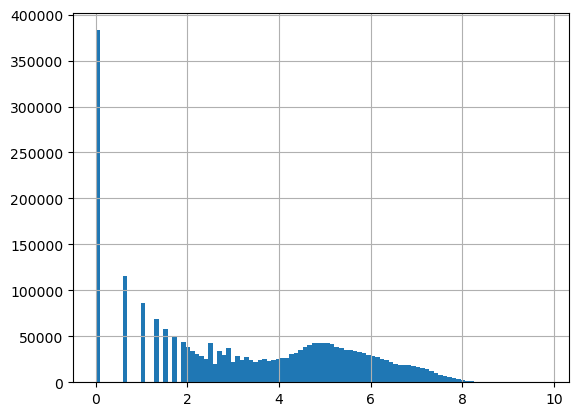

In [17]:
df_train.sales_transformed.hist(bins=100)

In [18]:
corr_matrix = df_train.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,price,price_7d_ma,price_30d_ma,price_7d_max,price_30d_max,price_7d_min,price_30d_min,tavg,tmin,tmax,prcp,day_of_week,is_weekend,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed
id,1.000000,0.012992,0.030270,0.036253,0.198075,0.006041,-0.003664,0.015515,-0.014736,-0.817397,-0.818783,-0.824594,-0.823294,-0.835867,-0.814266,-0.811657,0.054927,0.057089,0.079360,0.057217,-0.002669,-0.002025,0.051948,0.053217,0.053257,0.002745,0.003487,-0.000723,-0.008749,-0.014925,-0.012790,0.012340
store_nbr,0.012992,1.000000,0.002174,0.060037,0.017163,-0.320501,-0.203929,-0.412796,-0.074281,-0.009935,-0.009886,-0.009738,-0.009897,-0.009751,-0.009869,-0.009711,-0.001463,0.000092,-0.001271,0.000329,0.000012,0.000024,0.002453,0.002445,0.002445,0.000061,0.000046,-0.000027,0.003776,-0.002484,-0.001629,0.040044
family,0.030270,0.002174,1.000000,-0.141874,-0.059490,0.003795,0.006691,-0.003727,0.008884,-0.031051,-0.030880,-0.030258,-0.030715,-0.029767,-0.030976,-0.030605,0.004003,0.002673,-0.000939,-0.002563,-0.000022,-0.000006,0.001110,0.001151,0.001151,0.000099,-0.000047,0.000030,-0.000024,0.000127,0.000119,-0.138402
sales,0.036253,0.060037,-0.141874,1.000000,0.419392,0.058494,0.077423,-0.112970,0.036900,-0.031459,-0.031225,-0.030609,-0.031182,-0.030944,-0.031356,-0.030386,0.008631,0.006027,0.010736,0.003034,0.041207,0.043418,0.020578,0.019380,0.019185,-0.013828,0.001119,0.007129,-0.003919,-0.001392,-0.001723,0.553519
onpromotion,0.198075,0.017163,-0.059490,0.419392,1.000000,0.007209,0.014569,-0.012235,0.002559,-0.142015,-0.142547,-0.144866,-0.143992,-0.147876,-0.141406,-0.142011,0.016379,0.009481,0.030694,0.018575,-0.003091,-0.000392,0.027823,0.028272,0.028172,0.002138,0.002828,-0.001185,-0.002854,-0.002938,-0.002686,0.315497
city,0.006041,-0.320501,0.003795,0.058494,0.007209,1.000000,0.483648,-0.083821,0.092464,-0.005939,-0.005936,-0.005954,-0.005972,-0.006029,-0.005908,-0.005876,0.000609,0.000684,0.000879,0.000387,-0.000019,-0.000020,0.000180,0.000182,0.000183,-0.000066,0.000038,0.000032,-0.010289,0.003878,0.001920,0.051965
state,-0.003664,-0.203929,0.006691,0.077423,0.014569,0.483648,1.000000,-0.233032,0.163249,0.003102,0.003132,0.003224,0.003128,0.003247,0.003126,0.003185,-0.001107,-0.000038,-0.000765,0.000226,0.000001,-0.000002,-0.000977,-0.000997,-0.000997,-0.000101,0.000019,0.000029,-0.008107,0.006184,0.004141,0.080080
store_type,0.015515,-0.412796,-0.003727,-0.112970,-0.012235,-0.083821,-0.233032,1.000000,-0.278951,-0.015220,-0.015234,-0.015294,-0.015232,-0.015345,-0.015218,-0.015245,0.001787,0.001451,0.001048,0.000348,-0.000068,-0.000059,0.004735,0.004776,0.004776,0.000210,0.000019,0.000089,0.005480,0.000317,0.001127,-0.075634
cluster,-0.014736,-0.074281,0.008884,0.036900,0.002559,0.092464,0.163249,-0.278951,1.000000,0.012680,0.012817,0.013312,0.012955,0.013721,0.012693,0.012865,-0.005024,-0.001269,-0.005684,-0.000789,0.000037,0.000027,-0.000066,-0.000125,-0.000126,-0.000086,-0.000023,0.000011,-0.008274,-0.000111,-0.001356,0.025172
price,-0.817397,-0.009935,-0.031051,-0.031459,-0.142015,-0.005939,0.003102,-0.015220,0.012680,1.000000,0.998626,0.992139,0.998266,0.989082,0.998411,0.992942,-0.210361,-0.108715,-0.165945,-0.017775,0.002433,0.002321,0.005475,0.003470,0.003445,-0.001022,-0.001599,0.000248,0.003796,0.004228,0.003188,-0.017024


In [19]:
corr_matrix.loc['sales_transformed'].abs().sort_values()

holiday_description          0.002101
holiday_description_clean    0.002478
is_wage_day                  0.002614
day_of_month                 0.004291
holiday_type                 0.004777
is_wage_day_after            0.005451
prcp                         0.006079
tavg                         0.008925
tmin                         0.009445
id                           0.012340
price_30d_min                0.015373
price_30d_ma                 0.015568
tmax                         0.016343
price_30d_max                0.016376
price_7d_ma                  0.016775
price_7d_max                 0.016828
price_7d_min                 0.016930
price                        0.017024
cluster                      0.025172
day_of_week                  0.029216
is_weekend                   0.034203
week_of_year                 0.038771
day_of_year                  0.038868
month_of_year                0.039338
store_nbr                    0.040044
city                         0.051965
store_type  

In [20]:
models = {}
for fam in df_train.family.unique():
    print(f'Training {fam}...')
    df_train_fam = df_train[df_train.family==fam]
    X_train = df_train_fam.drop(['sales', 'date', 'sales_transformed', 'id'], axis=1, errors='ignore')
    y_train = df_train_fam.sales_transformed
    clf = lgb.LGBMRegressor()
    clf.fit(X_train, y_train)
    models[fam] = clf

Training 0...
Training 2...
Training 3...
Training 4...
Training 5...
Training 6...
Training 7...
Training 8...
Training 9...
Training 10...
Training 11...
Training 12...
Training 13...
Training 14...
Training 15...
Training 16...
Training 17...
Training 18...
Training 19...
Training 20...
Training 21...
Training 22...
Training 23...
Training 24...
Training 25...
Training 26...
Training 27...
Training 28...
Training 29...
Training 30...
Training 31...
Training 32...
Training 1...


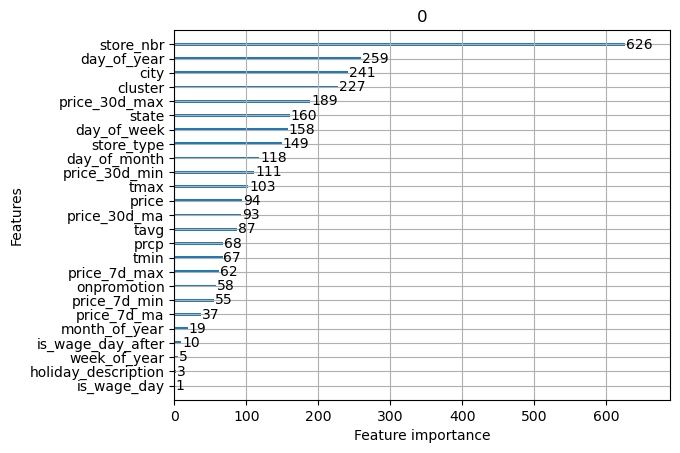

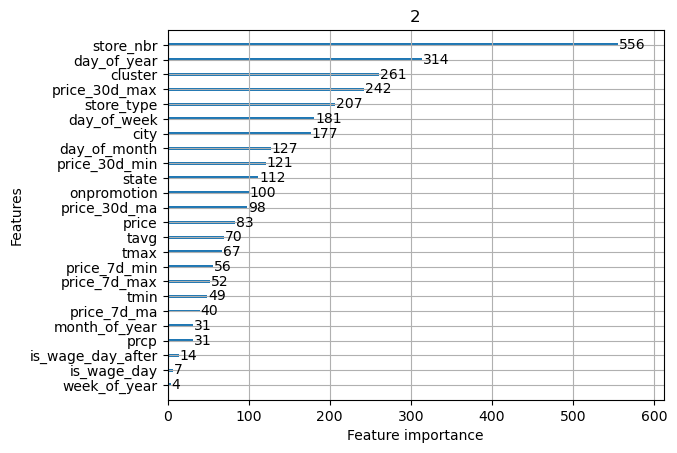

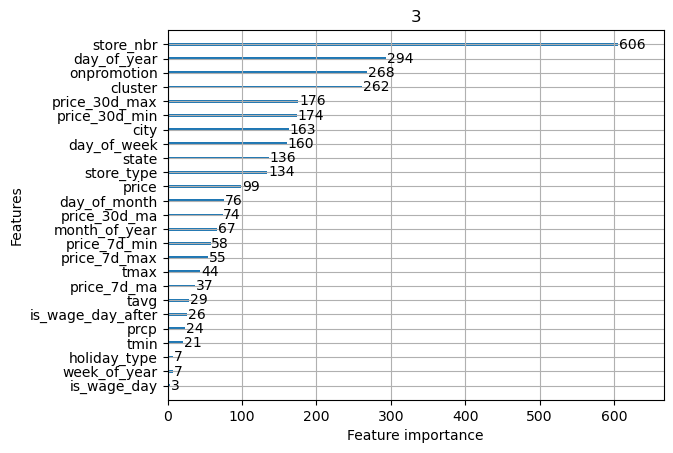

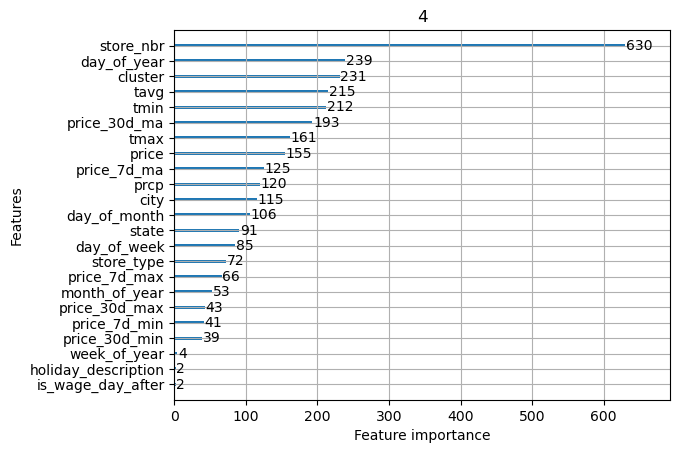

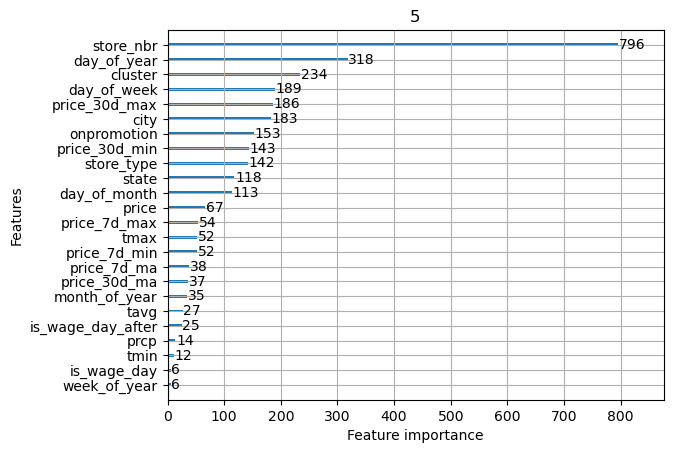

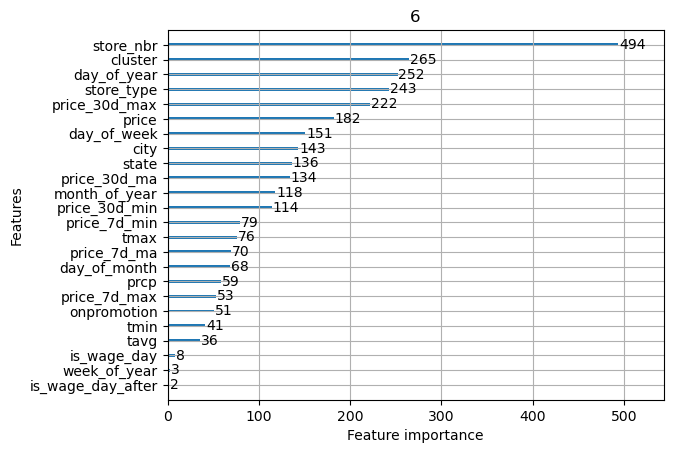

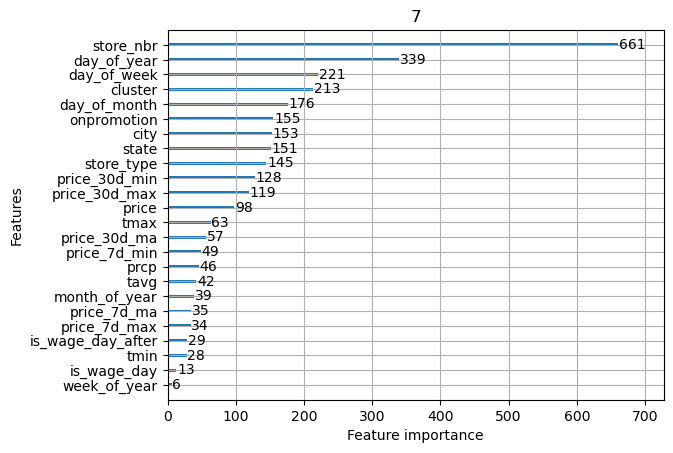

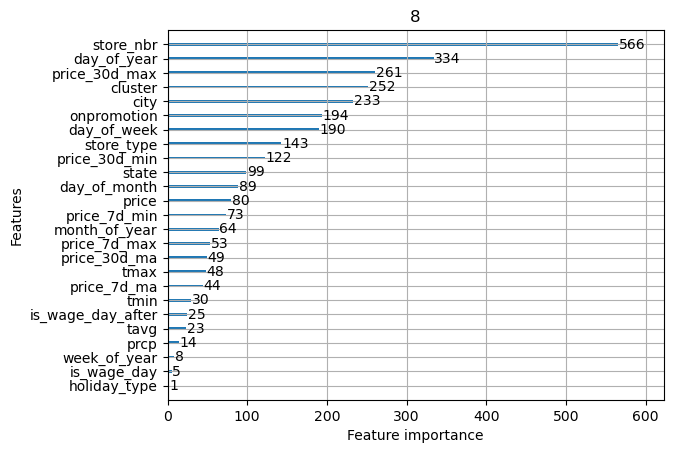

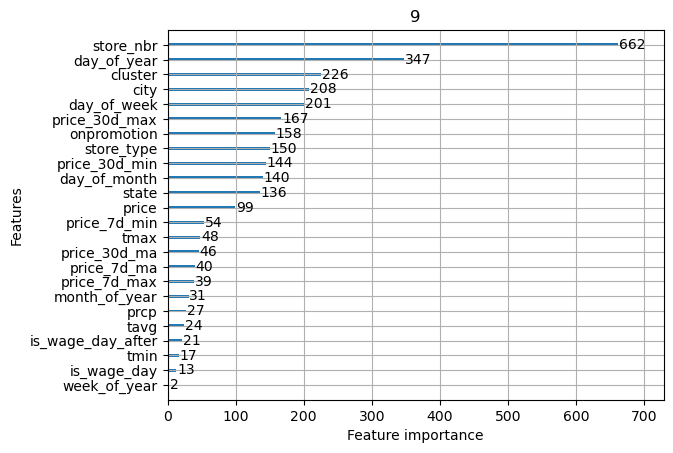

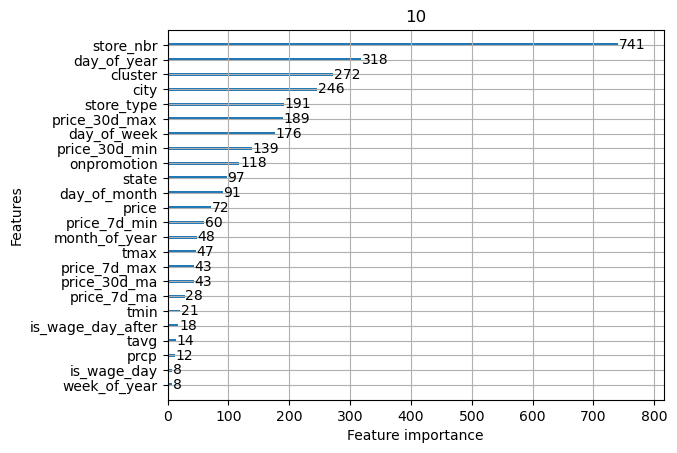

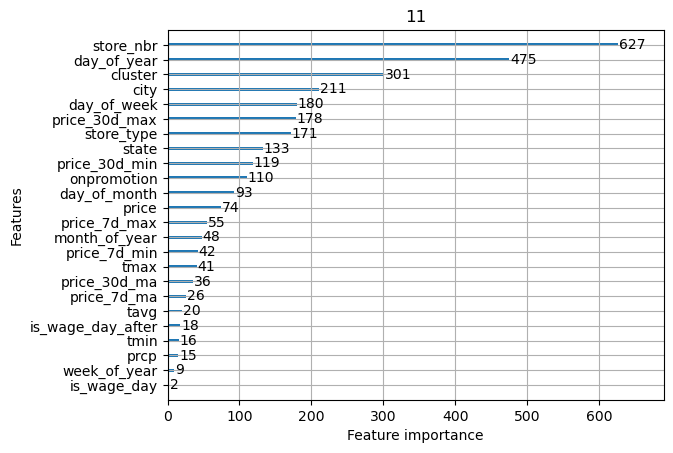

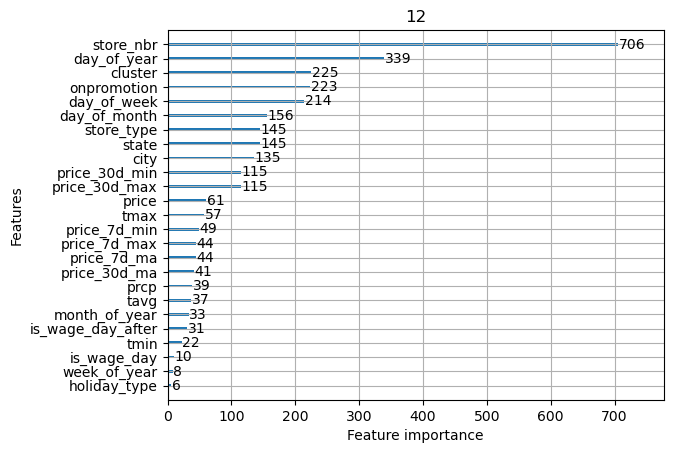

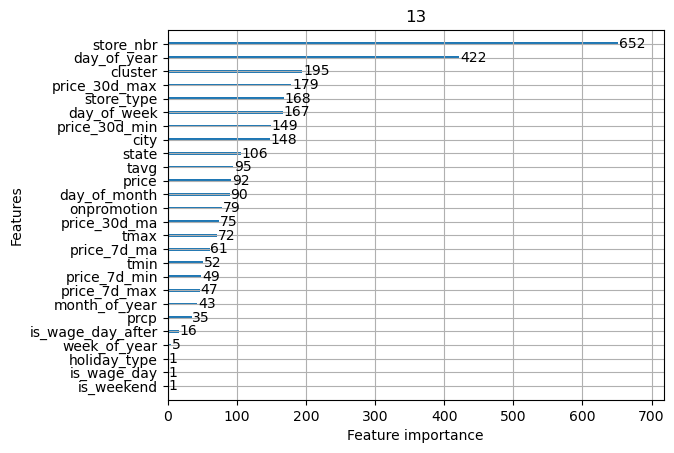

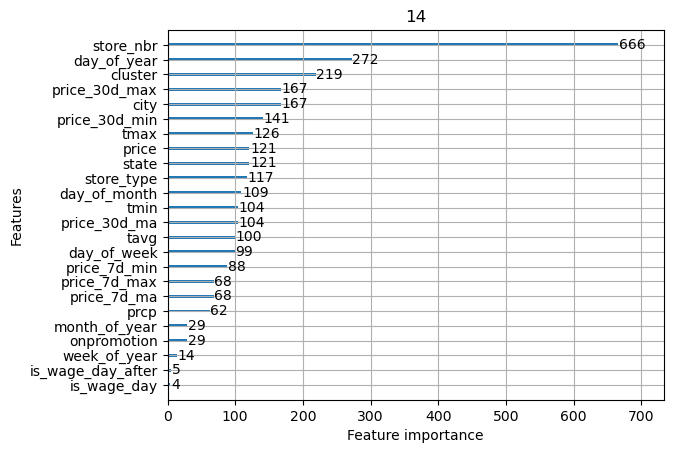

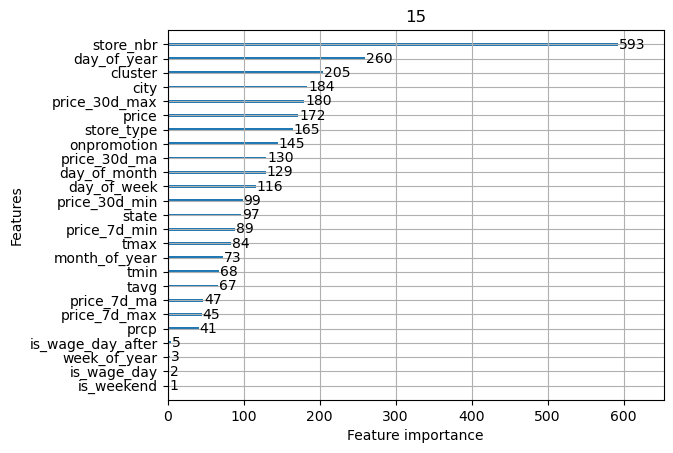

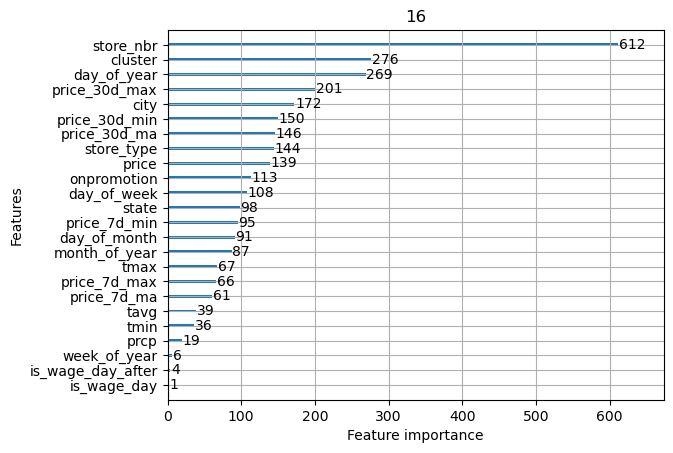

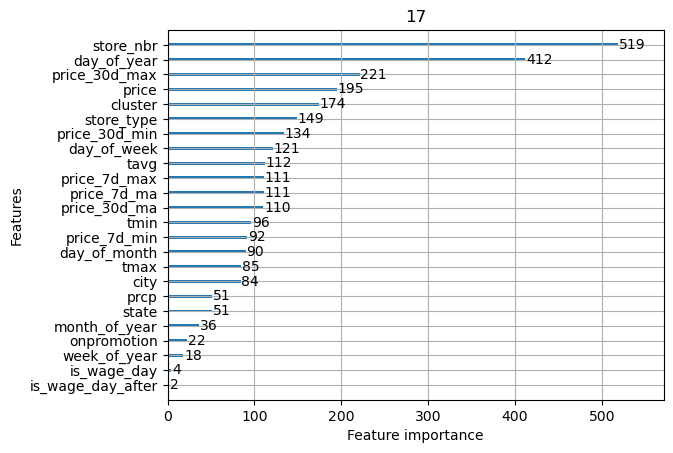

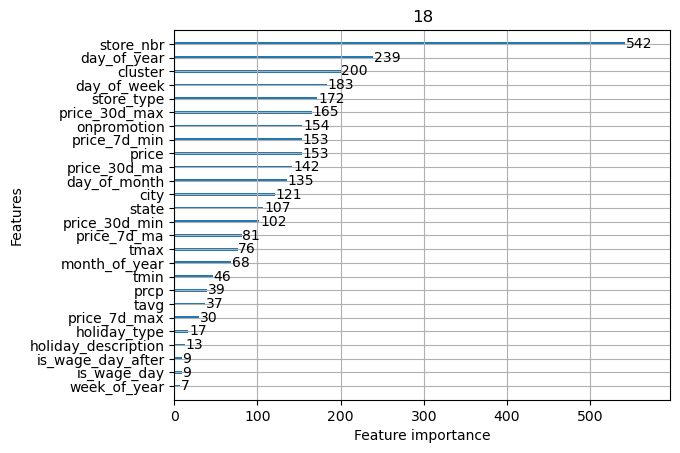

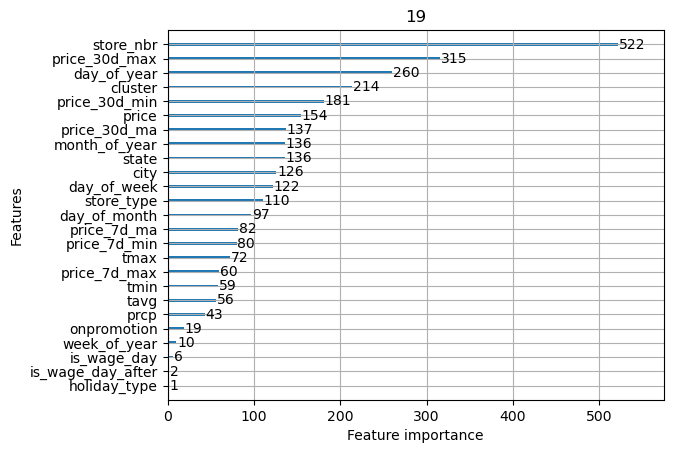

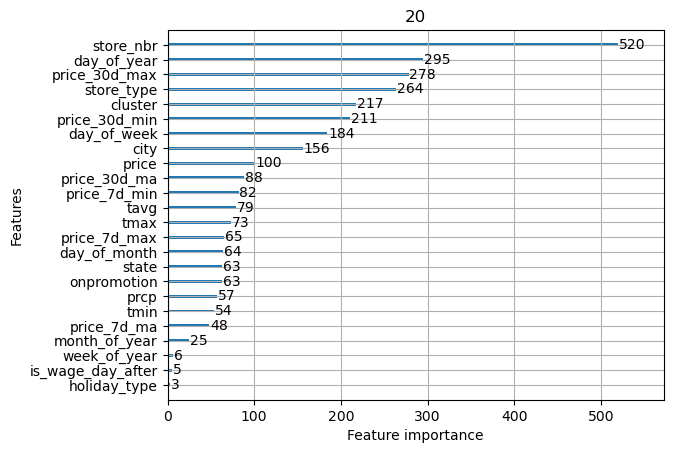

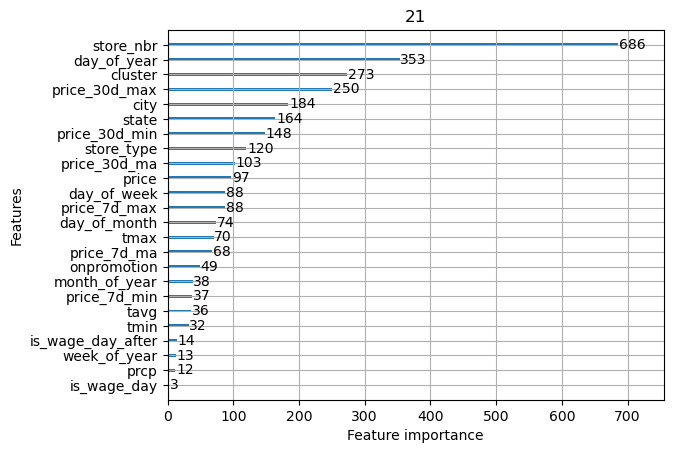

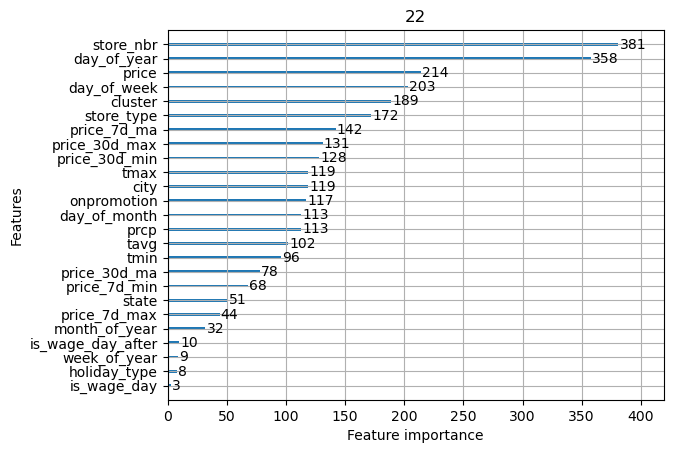

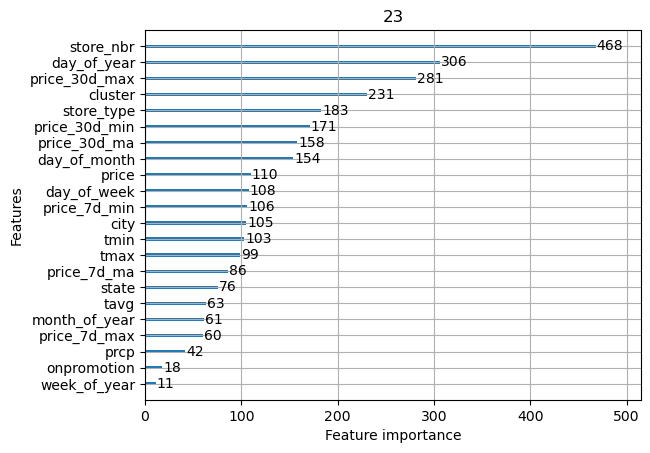

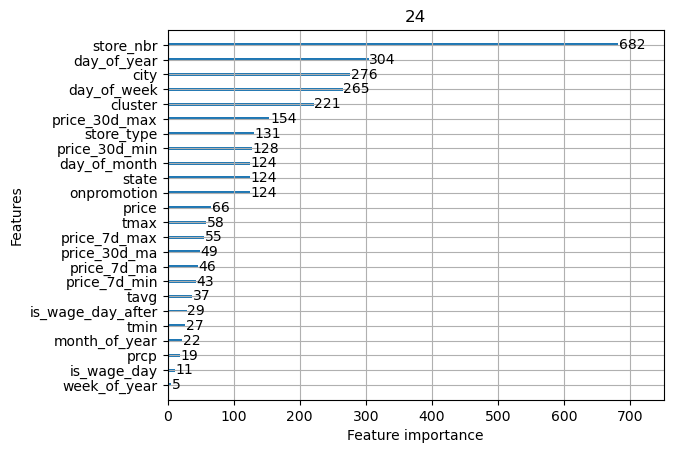

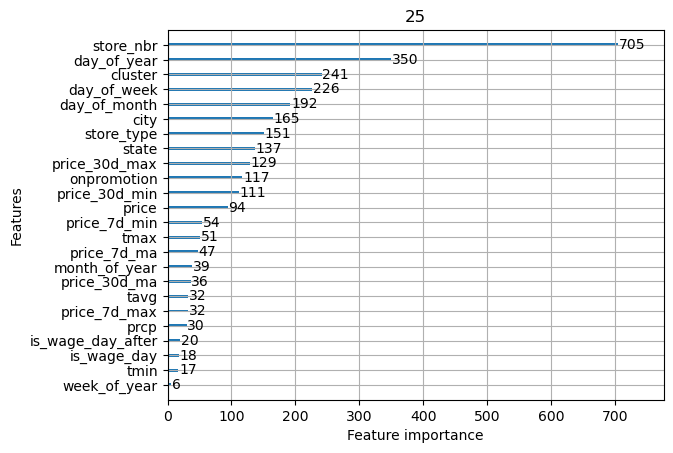

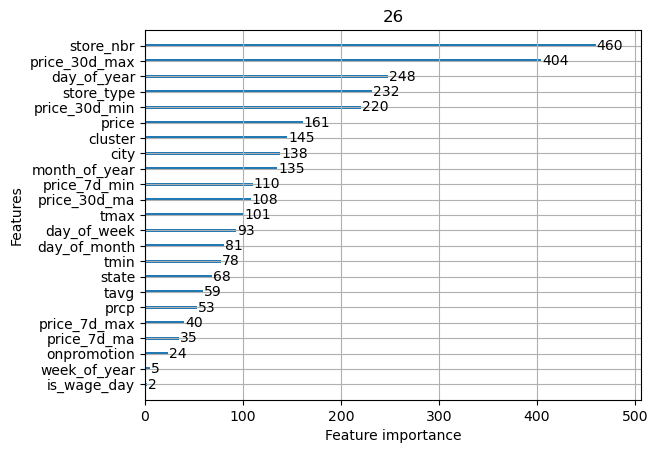

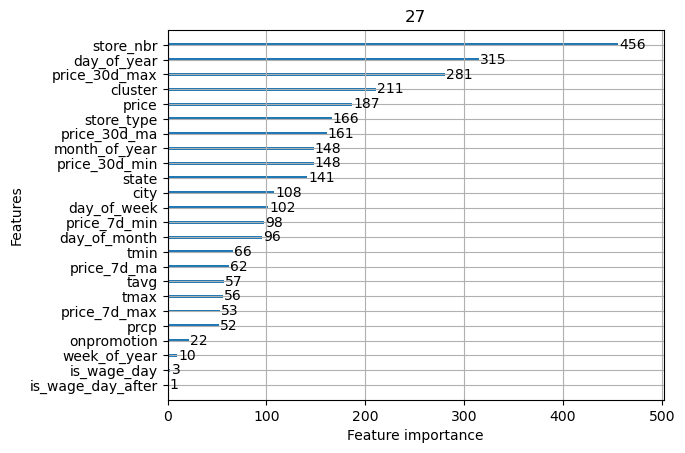

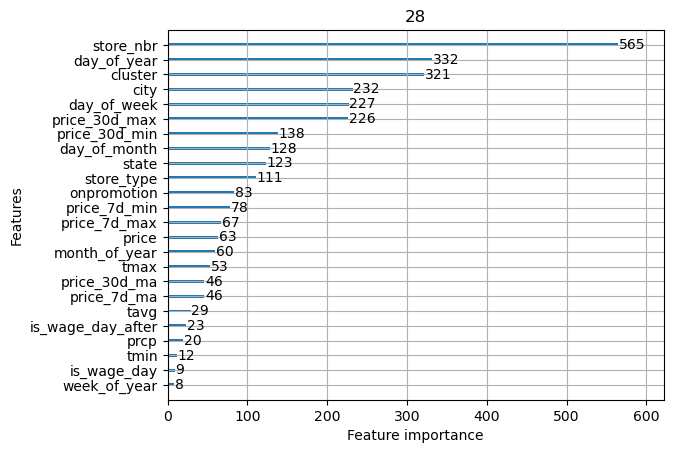

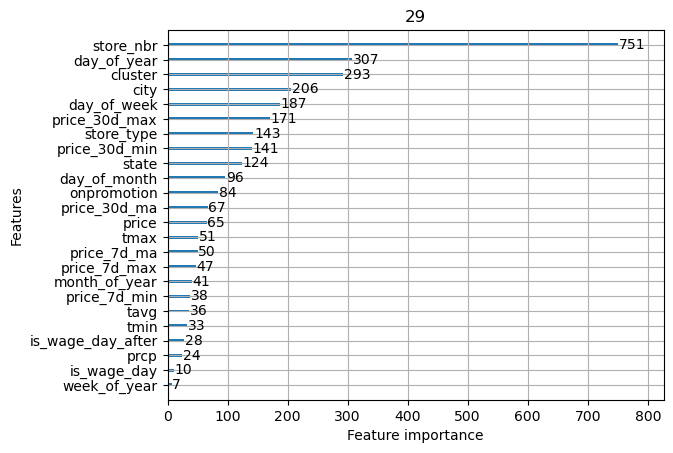

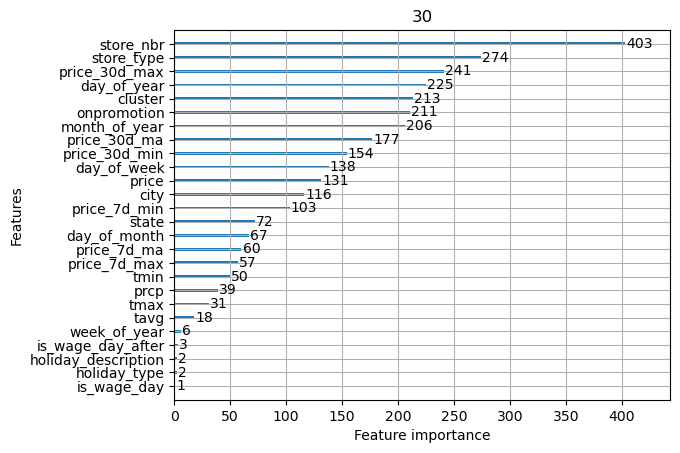

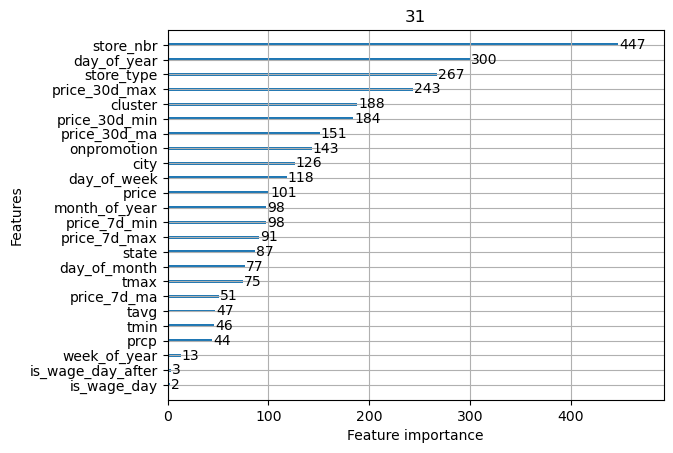

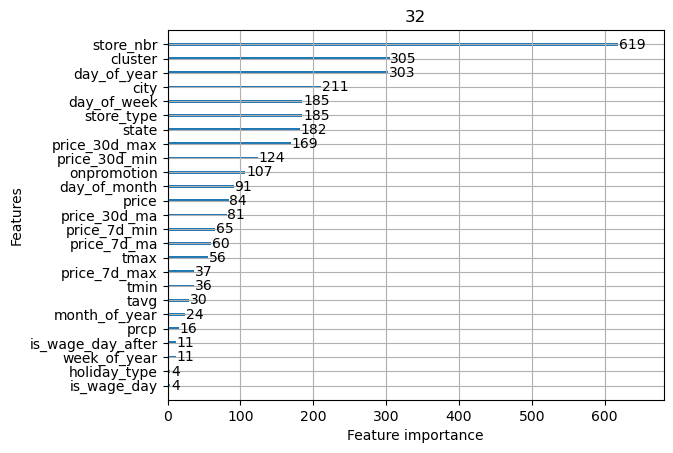

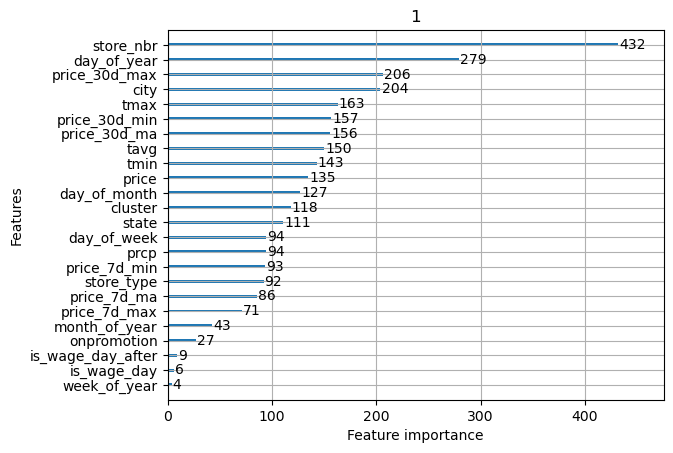

In [21]:
for fam, clf in models.items():
    lgb.plot_importance(clf, title=fam)

In [22]:
df_train['sales_pred'] = np.nan
for fam, clf in models.items():
    X_train = df_train[df_train.family==fam].drop(['sales', 'date', 'sales_transformed', 'id', 'sales_pred'], axis=1, errors='ignore')
    df_train.loc[df_train.family == fam, 'sales_pred'] = clf.predict(X_train)

In [23]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,2,1,2,False,False,2,4,3,1.080042,1.337213
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,3,1,3,False,False,2,4,3,1.356813,1.012125
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,4,1,4,False,False,2,4,3,1.356813,0.984004
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,5,1,5,False,False,2,4,3,1.742716,1.034356
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,6,1,6,False,False,2,4,3,1.080042,0.633356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,223,32,11,False,False,2,4,3,-0.000000,0.530935
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,224,33,12,False,False,2,4,3,0.685724,1.149636
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,225,33,13,False,False,2,4,3,1.080042,0.823852
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,226,33,14,False,False,2,4,3,-0.000000,0.695220


In [24]:
df_train[['date', 'family', 'sales_transformed', 'store_nbr']].pivot(index='date', columns=['store_nbr', 'family'], values='sales_transformed')
# df_train['sales_pred_inv'] = scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1))
# df_train['sales_pred_inv'] = pd.Series(scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1)).flatten())#.clip(lower=0)
df_train['sales_pred_inv'] = scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1))
df_train.sales_pred_inv = df_train.sales_pred_inv.clip(lower=0)
df_train
# scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1))
# df_train.sales_transformed.hist(bins=100)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred,sales_pred_inv
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,1,2,False,False,2,4,3,1.080042,1.337213,2.919001
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,1,3,False,False,2,4,3,1.356813,1.012125,1.796613
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,1,4,False,False,2,4,3,1.356813,0.984004,1.716616
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,1,5,False,False,2,4,3,1.742716,1.034356,1.861573
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,1,6,False,False,2,4,3,1.080042,0.633356,0.895878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,32,11,False,False,2,4,3,-0.000000,0.530935,0.708082
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,33,12,False,False,2,4,3,0.685724,1.149636,2.224272
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,33,13,False,False,2,4,3,1.080042,0.823852,1.303888
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,33,14,False,False,2,4,3,-0.000000,0.695220,1.019504


In [25]:
# scatter of pred vs true

In [26]:
df_agg = df_train[['date', 'family', 'store_nbr', 'sales']].pivot_table(index='date', columns='store_nbr', values='sales', aggfunc='sum')
# df_train[['date', 'family', 'sales']]

In [27]:
df_agg_pred = df_train[['date', 'family', 'sales_pred_inv', 'store_nbr']].pivot_table(index='date', columns='store_nbr', values='sales_pred_inv', aggfunc='sum')

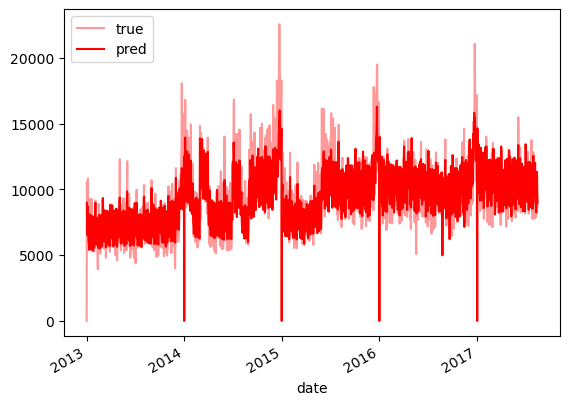

In [28]:
# df_agg.iloc[:,:20].plot(subplots=True)
lookback = -20000
z1 = 4
z2 = 5
# ax = df_agg[family].iloc[lookback:].plot()
# df_agg_pred[family].iloc[lookback:].plot(ax=ax)
ax = df_agg.fillna(0).iloc[lookback:,z1:z2].plot(alpha=0.4, color='r')
df_agg_pred.iloc[lookback:,z1:z2].plot(ax=ax, color='r')
# ax = df_agg.fillna(0).iloc[lookback:,z1:z2].plot(alpha=0.4, color='rgbyk')
# df_agg_pred.iloc[lookback:,z1:z2].plot(ax=ax, color='rgbyk')
ax.legend(['true', 'pred'])
#df_agg['sales_diff'].add(1,fill_value=0).cumprod()*s0

In [29]:
df_test, _, _ = preprocess(df_test_partial, label_encoder_map)
df_test['sales'] = np.nan
for fam in df_test.family.unique():
    clf = models[fam]
    X_test = df_test[df_test.family==fam].drop(['date', 'date_timestamp', 'transactions', 'id', 'sales'], axis=1, errors='ignore')
    df_test.loc[df_test.family==fam, 'sales'] = scaler.inverse_transform(clf.predict(X_test).reshape(-1, 1))
    

df_test.sales = df_test.sales.clip(lower=0)

merging...
computing label encoding...


<Axes: xlabel='date'>

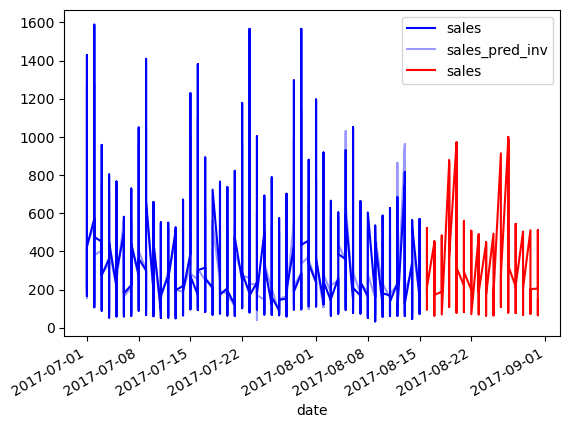

In [30]:
fam = 18
start = '2017-07-01'
ax = df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales']].plot(x='date', y='sales', color='b')
df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales_pred_inv']].plot(x='date', y='sales_pred_inv', alpha=0.4, color='b', ax=ax)
df_test[df_test.family==fam][['date', 'sales']].plot(x='date', y='sales', ax=ax, color='r')

In [31]:
df_train[df_train.family==fam]

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred,sales_pred_inv
355195,650448,2014-01-02,1,18,234.0,0,18,12,3,13,...,1,2,False,False,2,4,3,5.020929,5.083505,252.113254
356533,652230,2014-01-03,1,18,204.0,0,18,12,3,13,...,1,3,False,False,2,4,3,4.905451,4.987882,224.978804
357889,654012,2014-01-04,1,18,228.0,0,18,12,3,13,...,1,4,False,False,2,4,3,4.999098,5.138582,269.245967
359255,655794,2014-01-05,1,18,97.0,0,18,12,3,13,...,1,5,False,False,2,4,3,4.272851,4.738016,167.344235
360621,657576,2014-01-06,1,18,157.0,0,18,12,3,13,...,1,6,False,False,2,4,3,4.683898,4.984505,224.077313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437984,2993613,2017-08-11,54,18,163.0,6,5,10,2,3,...,32,11,False,False,2,4,3,4.715718,4.691011,158.321403
2439713,2995395,2017-08-12,54,18,234.0,6,5,10,2,3,...,33,12,False,False,2,4,3,5.020929,5.058052,244.577941
2441442,2997177,2017-08-13,54,18,306.0,6,5,10,2,3,...,33,13,False,False,2,4,3,5.245491,5.222048,297.521683
2443171,2998959,2017-08-14,54,18,175.0,5,5,10,2,3,...,33,14,False,False,2,4,3,4.775904,4.868190,195.186349


In [32]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,price,...,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales
0,3000888,2017-08-16,1,0,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,3,2.959708
1,3000889,2017-08-16,1,1,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,3,0.021594
2,3000890,2017-08-16,1,2,2,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,3,5.845020
3,3000891,2017-08-16,1,3,20,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,3,2167.751844
4,3000892,2017-08-16,1,4,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,3,0.056578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,3016657,2017-08-24,50,28,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,3,339.325787
15770,3016658,2017-08-24,50,29,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,3,96.890246
15771,3016659,2017-08-24,50,30,2,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,3,1907.490325
15772,3016660,2017-08-24,50,31,13,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,3,227.336021


In [33]:
df_test[['id', 'sales']].to_csv('/kaggle/working/out.csv', index=False)